## Python porting of ZLSMA - Zero Lag LSMA by veryfid (clean copy)

<https://ru.tradingview.com/script/3LGnSrQN-ZLSMA-Zero-Lag-LSMA/>

>Developed by [@edyatl](https://github.com/edyatl) January 2023 <edyatl@yandex.ru>

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as tl

# Nicest style for  plots
sns.set(style="ticks")

### Original Indicator code

```python
study(title = "ZLSMA - Zero Lag LSMA", shorttitle="ZLSMA", overlay=true, resolution="")
length = input(title="Length", type=input.integer, defval=32)
offset = input(title="Offset", type=input.integer, defval=0)
src = input(close, title="Source")
lsma = linreg(src, length, offset)
lsma2 = linreg(lsma, length, offset)
eq= lsma-lsma2
zlsma = lsma+eq

plot(zlsma, color=color.yellow, linewidth=3)
```

**formula:** `linreg = intercept + slope * (length - 1 - offset)`

`linreg(source, length, offset) → series[float]`

where 
* **length** is the y argument, 
* **offset** is the z argument, 
* **intercept** and **slope** are the values calculated with the least squares method on source series (x argument)

Download [Dataset](https://data.binance.vision/?prefix=data/spot/daily/klines/BTCUSDT/) from Binance and unzip

In [2]:
dataset_path = "../"
short_col_names = [
    "open_time",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "close_time",
    "qav",
    "num_trades",
    "taker_base_vol",
    "taker_quote_vol",
    "ignore",
]

In [3]:
# Load Dataset
data = pd.read_csv(
    dataset_path + "BTCUSDT-15m-2023-01-20.csv",
    names=short_col_names,
)

In [4]:
data["open_time"] = pd.to_datetime(data["open_time"], unit="ms")
data["close_time"] = pd.to_datetime(data["close_time"], unit="ms")
data.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,2023-01-20 00:00:00,21071.59,21098.00,21048.70,21060.63,2469.02977,2023-01-20 00:14:59.999,5.202850e+07,68960,1192.43392,2.512823e+07,0
1,2023-01-20 00:15:00,21060.63,21113.32,21032.72,21102.38,2616.60449,2023-01-20 00:29:59.999,5.512145e+07,68162,1362.11721,2.869626e+07,0
2,2023-01-20 00:30:00,21103.22,21121.42,21050.24,21061.88,2358.03935,2023-01-20 00:44:59.999,4.970823e+07,64940,1140.56469,2.404463e+07,0
3,2023-01-20 00:45:00,21061.88,21073.35,21028.95,21054.74,1951.29264,2023-01-20 00:59:59.999,4.106924e+07,54532,971.54621,2.044873e+07,0
4,2023-01-20 01:00:00,21054.02,21063.54,21013.96,21061.42,2132.88842,2023-01-20 01:14:59.999,4.486771e+07,54574,1065.50163,2.241487e+07,0


In [5]:
length: int = 32  # 32
offset: int = 10
src: pd.Series = data["close"]

### Using [Python wrapper](https://github.com/TA-Lib/ta-lib-python) for [TA-LIB](http://ta-lib.org/) based on Cython instead of SWIG.

In [6]:
def linreg(src: pd.Series, length: int = None, offset: int = None) -> pd.Series:
    """Indicator: Linear Regression with TA-LIB module"""
    # Validate arguments
    src = None if src.size < length or not isinstance(src, pd.Series) else src
    length = int(length) if isinstance(length, int) and length > 0 else 32
    offset = int(offset) if isinstance(offset, int) else 0

    # Offset
    if offset != 0:
        # linreg = intercept + slope * (length - 1 - offset)
        return tl.LINEARREG_INTERCEPT(src, length) + tl.LINEARREG_SLOPE(src, length) * (
            length - 1 - offset
        )

    return tl.LINEARREG(src, length)

In [7]:
lsma: pd.Series = linreg(src, length, offset) 
lsma2: pd.Series = linreg(lsma, length, offset)

In [8]:
eq = lsma - lsma2
zlsma = lsma + eq
data["zlsma"] = zlsma
data[["open_time", "close_time", "zlsma"]].tail(10)

,open_time,close_time,zlsma
86,2023-01-20 21:30:00,2023-01-20 21:44:59.999,22000.504618
87,2023-01-20 21:45:00,2023-01-20 21:59:59.999,22075.704480
88,2023-01-20 22:00:00,2023-01-20 22:14:59.999,22155.729763
89,2023-01-20 22:15:00,2023-01-20 22:29:59.999,22247.701926
90,2023-01-20 22:30:00,2023-01-20 22:44:59.999,22339.042077
91,2023-01-20 22:45:00,2023-01-20 22:59:59.999,22418.205302
92,2023-01-20 23:00:00,2023-01-20 23:14:59.999,22496.443445
93,2023-01-20 23:15:00,2023-01-20 23:29:59.999,22567.265257
94,2023-01-20 23:30:00,2023-01-20 23:44:59.999,22633.613690
95,2023-01-20 23:45:00,2023-01-20 23:59:59.999,22691.651051


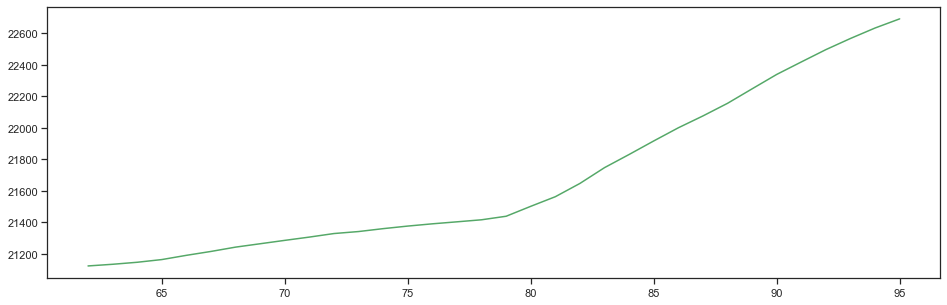

In [9]:
plt.figure(figsize=(16, 5))
plt.plot(range(zlsma.size), zlsma, color="g")
plt.show()